In [ ]:
!pip install git+http://hf.co/usm3d/tools.git    

In [1]:
import torch
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    PerspectiveCameras
)
from pytorch3d.structures import Pointclouds

In [2]:
import webdataset as wds 
import numpy as np
from huggingface_hub import hf_hub_download
from hoho import proc
from tqdm import tqdm
import sys
sys.path.append('..')
from handcrafted_solution import *
import trimesh
import hoho
from hoho import *
from hoho.vis import line
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm

from handcrafted_solution import *

def to_K(f, cx, cy):
    K = np.eye(3)
    K[0,0] = K[1,1] = f
    K[0,2] = cx
    K[1,2] = cy
    return K

def quaternion_to_rotation_matrix(qvec):
    qw, qx, qy, qz = qvec
    R = np.array([
        [1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]
    ])
    return R

In [3]:
import huggingface_hub  
huggingface_hub.login()

# Loading part of training data

For simplicity we are showing example only on a once shard of data

In [519]:
# One shard of the dataset
dataset = wds.WebDataset(hf_hub_download(repo_id='usm3d/hoho-train-set',
            filename='data/train/hoho_v3_000-of-032.tar.gz',
            repo_type="dataset"))

dataset = dataset.decode()
dataset = dataset.map(proc)

for ki, entry in enumerate(dataset):
    human_entry = convert_entry_to_human_readable(entry)
    # print (entry.keys())
    if ki >= 33:
        break
    

In [520]:
# Download all the datasets:
# for i in range(32):
#     dataset = wds.WebDataset(hf_hub_download(repo_id='usm3d/hoho-train-set',
#             filename=f'data/train/hoho_v3_{str(i).zfill(3)}-of-032.tar.gz',
#             repo_type="dataset"))

In [521]:
print(len(human_entry['gestalt']))
human_entry['points3d'][1781]

4


Point3D(id=1781, xyz=array([276.77694431, 553.80291416,  82.91044522]), rgb=array([ 92, 106, 119]), error=array(1.19906191), image_ids=array([6, 5, 7]), point2D_idxs=array([5306, 5147, 4498]))

# Visualizing inputs

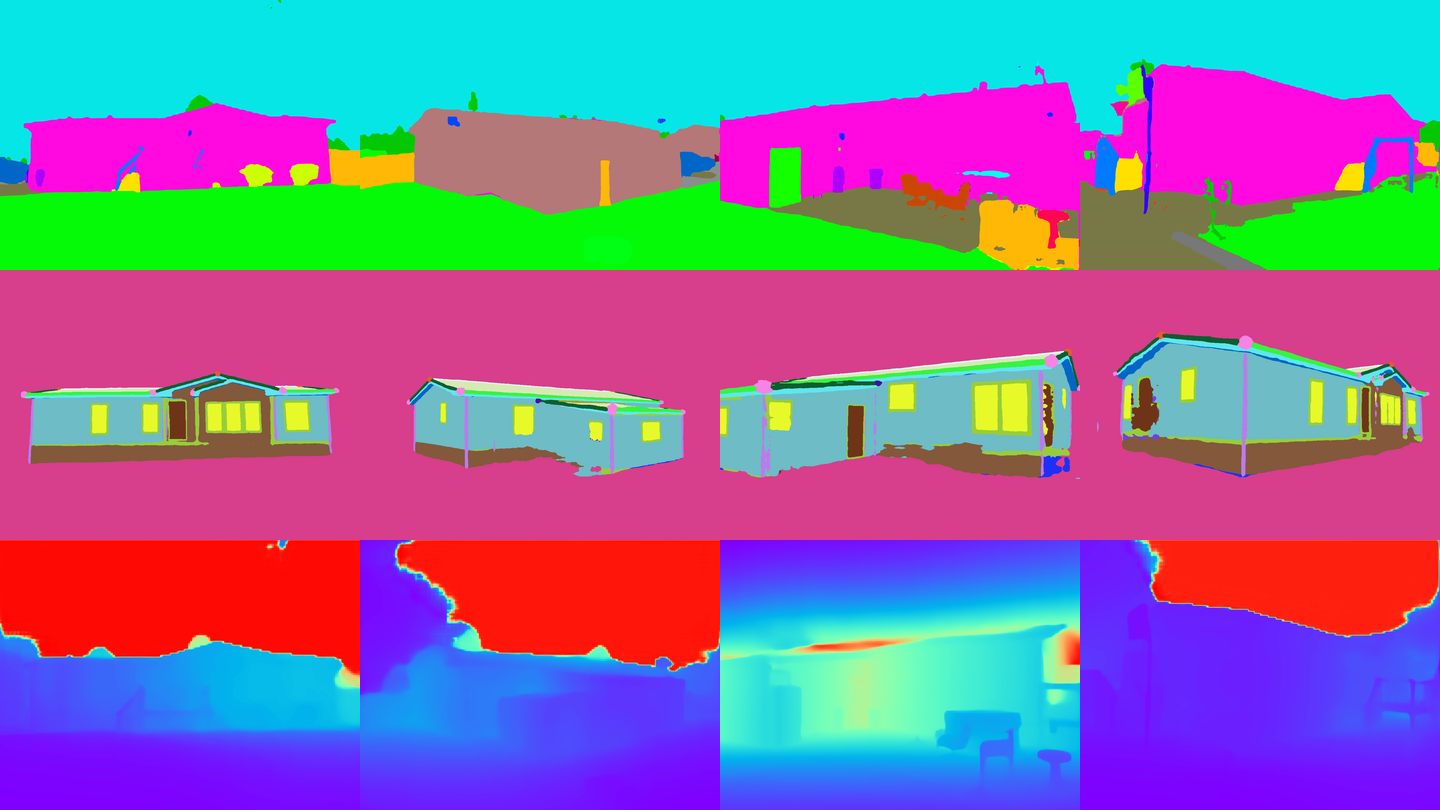

In [522]:
# for ki in range(len(human_entry['gestalt'])):
#     plt.figure()
#     plt.imshow(human_entry['gestalt'][ki])
#     plt.title('Gestalt segmentation')

# plt.figure()
# depth = np.array(human_entry['depthcm'][0])/100.
# depth[depth>20] = 0
# depth = depth/depth.max()
# plt.title('Monodepth')
# plt.imshow(depth, cmap='rainbow')

vis.visualize_order_images(human_entry)

In [673]:
col_cams = [hoho.Rt_to_eye_target(human_entry['ade20k'][0], to_K(*human_entry['cameras'][1].params), quaternion_to_rotation_matrix(colmap_img.qvec), colmap_img.tvec) for colmap_img in human_entry['images'].values()]
eye, target, up, fov = col_cams[0]


cameras, images, points3D = human_entry['cameras'], human_entry['images'], human_entry['points3d']
xyz = np.stack([p.xyz for p in points3D.values()])
color = np.stack([p.rgb for p in points3D.values()])
pcd = trimesh.Scene([trimesh.PointCloud(vertices=xyz, colors=color)])

V, E = human_entry['wf_vertices'], human_entry['wf_edges']
wf = vis.show_wf(human_entry)

ax = [line((0,0,0), 1200*b, c=255*b, radius=15) for b in np.eye(3)]

u = trimesh.Trimesh(vertices=human_entry['mesh_vertices'] , faces=human_entry['mesh_faces'][:, 1:])

cams = trimesh.Scene([line(eye, (eye + 200*(target - eye)), radius=6) for eye, target, up, fov in itertools.starmap(hoho.Rt_to_eye_target, zip(*[human_entry[k] for k in 'ade20k K R t'.split()]))])
cams_colmap = trimesh.Scene([line(eye, (eye + 200*(target - eye)), radius=6, c=(0,0,255)) for eye, target, up, fov in col_cams])

gestalt_camcet = np.stack([eye for eye, target, up, fov in itertools.starmap(hoho.Rt_to_eye_target, zip(*[human_entry[k] for k in 'ade20k K R t'.split()]))])
col_camcet = np.stack([eye for eye, target, up, fov in col_cams])
gestalt_to_colmap_cams = [np.argmin(((gcam - col_camcet)**2).sum(1)**0.5)+1 for gcam in gestalt_camcet]

trimesh.Scene([
        # u,
        # ax,
        cams,
        cams_colmap,
        pcd,
        *wf
    ]).show()

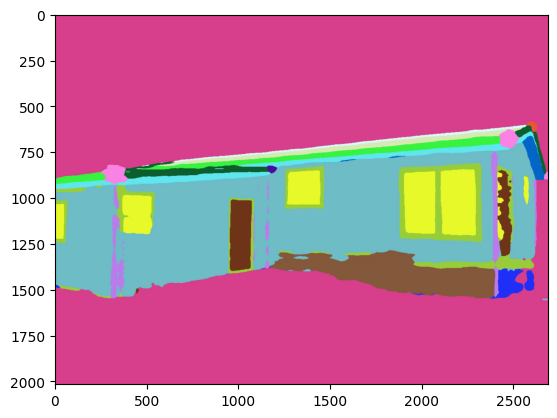

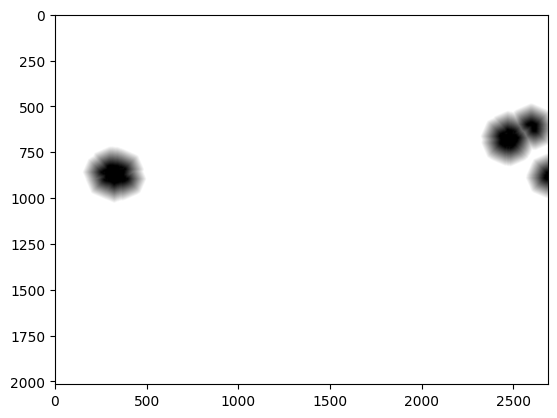

In [524]:
ki = 2
clr_th = 2.5

gest = np.array(human_entry['gestalt'][ki])
apex_color = np.array(gestalt_color_mapping['apex'])
apex_mask = cv2.inRange(gest,  apex_color-clr_th, apex_color+clr_th)
eave_end_color = np.array(gestalt_color_mapping['eave_end_point'])
eave_end_mask = cv2.inRange(gest,  eave_end_color-clr_th, eave_end_color+clr_th)
vert_mask = apex_mask + eave_end_mask
# vert_mask = cv2.dilate(vert_mask, np.ones((5,5)), iterations = 7)
vert_mask = (vert_mask > 0).astype(np.uint8)


dist = cv2.distanceTransform(1-vert_mask, cv2.DIST_L2, 3)
dist[dist > 100] = 100
ndist = np.zeros_like(dist)
ndist = cv2.normalize(dist, ndist, 0, 1.0, cv2.NORM_MINMAX)

# f, axarr = plt.subplots(1,2) 
# axarr[0].imshow(gest)
# axarr[1].imshow(dist, cmap='gray')
plt.imshow(gest)
plt.figure()
plt.imshow(ndist, cmap='gray')


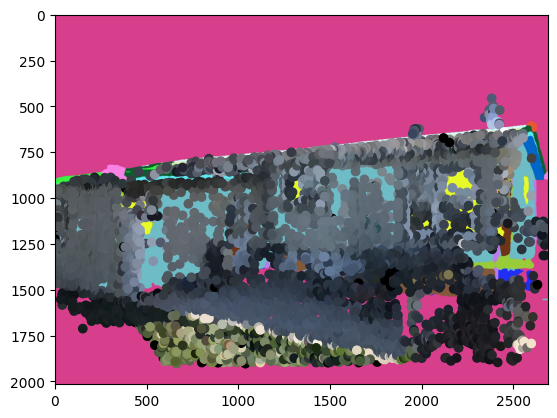

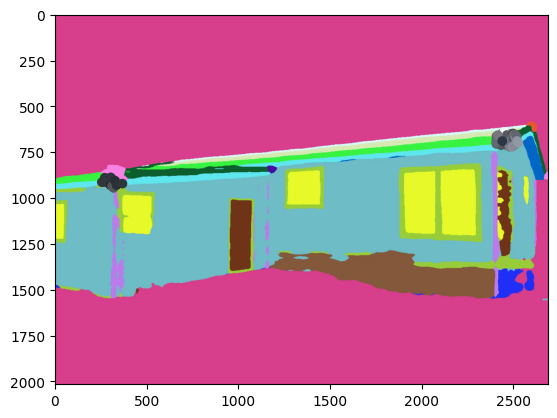

In [525]:
device = 'cuda:0'
height = cameras[1].height
width = cameras[1].width
N = len(gestalt_to_colmap_cams)
cki = gestalt_to_colmap_cams[ki]

# K, R, T = human_entry['K'], human_entry['R'], human_entry['t']
K = to_K(*human_entry['cameras'][1].params)[None].repeat(N, 0)
R = np.stack([quaternion_to_rotation_matrix(human_entry['images'][gestalt_to_colmap_cams[ind]].qvec) for ind in range(N)])
T = np.stack([human_entry['images'][gestalt_to_colmap_cams[ind]].tvec for ind in range(N)])

R = np.linalg.inv(R)
image_size=torch.Tensor([height, width]).repeat(N, 1)

verts = torch.from_numpy(xyz.astype(np.float32)).to(device)
clrs = torch.from_numpy(color.astype(np.float32)).to(device)
point_cloud = Pointclouds(points=[verts], features=[clrs])

pyt_cameras = PerspectiveCameras(device=device, R=R, T=T, in_ndc=False, focal_length=K[:, 0, :1], principal_point=K[:, :2, 2], image_size=image_size)
raster_settings = PointsRasterizationSettings(
    image_size=[height, width], 
    radius = 0.02,
    points_per_pixel = 10
)

renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=pyt_cameras[ki], raster_settings=raster_settings),
    compositor=NormWeightedCompositor()
)
images = renderer(point_cloud)

in_this_image = np.array([cki in p.image_ids for p in points3D.values()])
uv = torch.round(pyt_cameras[ki].transform_points(verts)[:, :2]).cpu().numpy().astype(int)
uv_inl = (uv[:, 0] >= 0) * (uv[:, 1] >= 0) * (uv[:, 0] < width) * (uv[:, 1] < height) * in_this_image
uv = uv[uv_inl]
uv_clrs = clrs[uv_inl].cpu().numpy() / 255

vert_inl = dist[uv[:,1], uv[:,0]] < 20
vert_uv = uv[vert_inl]
vert_uv_clrs = uv_clrs[vert_inl]

plt.figure()
plt.imshow(gest)
# plt.imshow(images[0].cpu().numpy()[::-1,::-1]/255)
plt.scatter(uv[:, 0], uv[:, 1], c=uv_clrs)

plt.figure()
plt.imshow(gest)
plt.scatter(vert_uv[:, 0], vert_uv[:, 1], c=vert_uv_clrs)
# plt.scatter(uv[:, 0], uv[:, 1], c=uv_clrs)


In [760]:
clr_th = 2.5
device = 'cuda:0'
height = cameras[1].height
width = cameras[1].width
N = len(gestalt_to_colmap_cams)
K = to_K(*human_entry['cameras'][1].params)[None].repeat(N, 0)
R = np.stack([quaternion_to_rotation_matrix(human_entry['images'][gestalt_to_colmap_cams[ind]].qvec) for ind in range(N)])
T = np.stack([human_entry['images'][gestalt_to_colmap_cams[ind]].tvec for ind in range(N)])

R = np.linalg.inv(R)
image_size=torch.Tensor([height, width]).repeat(N, 1)
pyt_cameras = PerspectiveCameras(device=device, R=R, T=T, in_ndc=False, focal_length=K[:, 0, :1], principal_point=K[:, :2, 2], image_size=image_size)

verts = torch.from_numpy(xyz.astype(np.float32)).to(device)

apex_color = np.array(gestalt_color_mapping['apex'])
eave_end_color = np.array(gestalt_color_mapping['eave_end_point'])

dist_points = np.zeros((xyz.shape[0], ))
visible_counts = np.zeros((xyz.shape[0], ), dtype=int)
proj_uv = []
for ki in range(N):
    cki = gestalt_to_colmap_cams[ki]
    
    gest = np.array(human_entry['gestalt'][ki])
    apex_mask = cv2.inRange(gest,  apex_color-clr_th, apex_color+clr_th)
    eave_end_mask = cv2.inRange(gest,  eave_end_color-clr_th, eave_end_color+clr_th)
    vert_mask = apex_mask + eave_end_mask
    vert_mask = (vert_mask > 0).astype(np.uint8)
    
    dist = cv2.distanceTransform(1-vert_mask, cv2.DIST_L2, 3)
    dist[dist > 100] = 100
    ndist = np.zeros_like(dist)
    ndist = cv2.normalize(dist, ndist, 0, 1.0, cv2.NORM_MINMAX)
    
    in_this_image = np.array([cki in p.image_ids for p in points3D.values()])
    # tempind = 2103
    # print(in_this_image[tempind-1], cki, points3D[tempind].image_ids)
    uv = torch.round(pyt_cameras[ki].transform_points(verts)[:, :2]).cpu().numpy().astype(int)
    uv_inl = (uv[:, 0] >= 0) * (uv[:, 1] >= 0) * (uv[:, 0] < width) * (uv[:, 1] < height) * in_this_image
    proj_uv.append((uv, uv_inl))
    uv = uv[uv_inl]

    dist_points[uv_inl] += dist[uv[:,1], uv[:,0]]
    visible_counts[uv_inl] += 1
    
selected_points = (dist_points / (visible_counts + 1e-6)) <= 10
selected_points[visible_counts < 1] = False
print(selected_points.sum())

True 1 [5 7]
False 4 [5 7]
False 6 [5 7]
True 9 [5 7]
79


In [761]:
# np.array([p.id for p in points3D.values()])

array([10320,    47, 20800, ..., 14872,  4599, 12569])

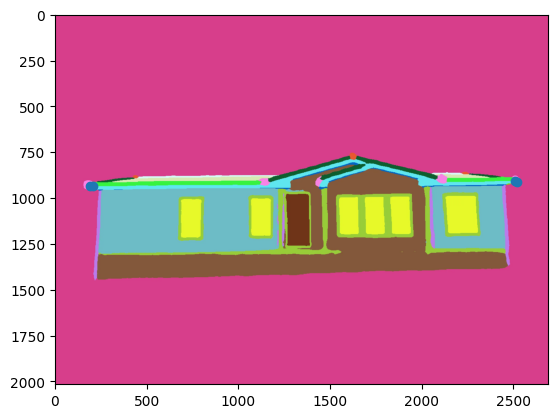

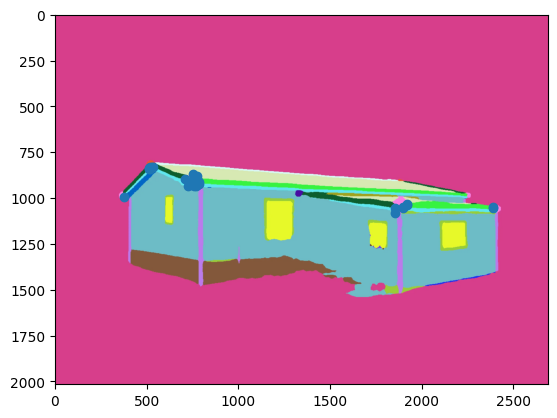

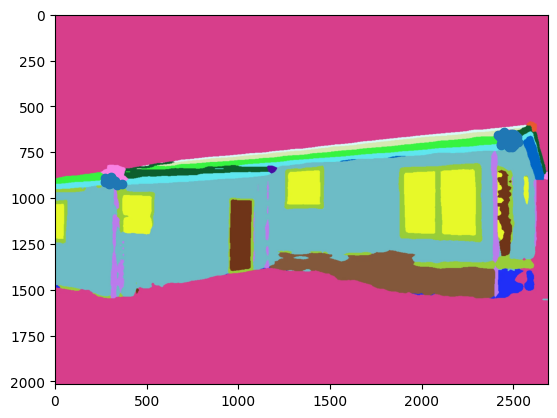

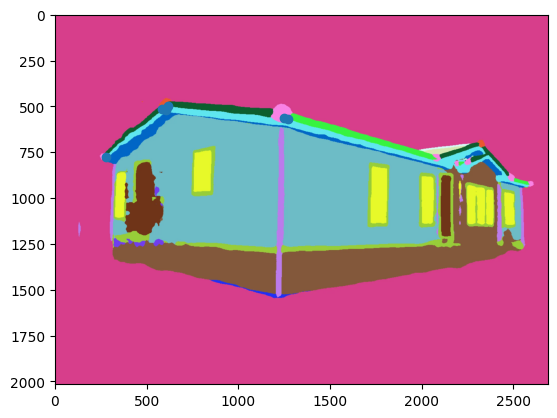

In [624]:
for ki in range(N):
    plt.figure()
    gest = np.array(human_entry['gestalt'][ki])
    plt.imshow(gest)
    uv, uv_inl = proj_uv[ki]
    uv = uv[uv_inl*selected_points]
    # uv = uv[selected_points]
    plt.scatter(uv[:, 0], uv[:, 1])


In [528]:
from pytorch3d.ops import ball_query
pnts = torch.from_numpy(xyz[selected_points].astype(np.float32))[None]
bdists, inds, nn = ball_query(pnts, pnts, K=3, radius=30) 
# dense_pnts = bdists[0].sum(1)[0] < 10**2
dense_pnts = (bdists[0] > 0).sum(1) == 2

In [607]:
bdists

tensor([[[0.],
         [0.]]])

In [618]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.3)
flags = cv2.KMEANS_RANDOM_CENTERS
retvals = []
centers = None
for tempi in range(1,11):
    retval, bestLabels, temp_centers = cv2.kmeans(xyz[selected_points][dense_pnts].astype(np.float32), tempi, None, criteria, 200,flags)
    cpnts = torch.from_numpy(temp_centers.astype(np.float32))[None]
    bdists, inds, nn = ball_query(cpnts, cpnts, K=1, radius=100) 
    if bdists.max() > 0:
        closest_nn = (bdists[bdists>0].min()**0.5).item()
    else:
        closest_nn = 100
    retvals.append(closest_nn)
    if closest_nn < 100:
        break
    centers = temp_centers
# plt.plot(retvals)

In [740]:
cpnts = torch.from_numpy(centers.astype(np.float32))[None]
pnts = torch.from_numpy(xyz[selected_points][dense_pnts].astype(np.float32))[None] 
bdists, inds, nn = ball_query(cpnts, pnts, K=1, radius=100) 
center_inds = np.arange(xyz.shape[0])
center_inds = center_inds[selected_points][dense_pnts][inds[0,:,0]]

In [739]:
# pcd_ours = trimesh.Scene([trimesh.PointCloud(vertices=xyz[selected_points], colors=color[selected_points])])
pcd_ours = trimesh.Scene([line(pnt, (pnt + [10, 0, 0]), radius=10, c=[0,0,255]) for pnt in xyz[selected_points][dense_pnts]])
# pcd_ours = trimesh.Scene([line(pnt, (pnt + [10, 0, 0]), radius=10, c=[0,0,255]) for pnt in xyz[selected_points]])
# centers_ours = trimesh.Scene([trimesh.PointCloud(vertices=centers)])
centers_ours = trimesh.Scene([line(pnt, (pnt + [20, 0, 0]), radius=20) for pnt in centers])
# centers_ours = trimesh.Scene([line(pnt, (pnt + [20, 0, 0]), radius=20) for pnt in xyz[center_inds]])
trimesh.Scene([
        # u,
        # ax,
        cams,
        cams_colmap,
        pcd_ours,
        centers_ours,
        *wf
    ]).show()

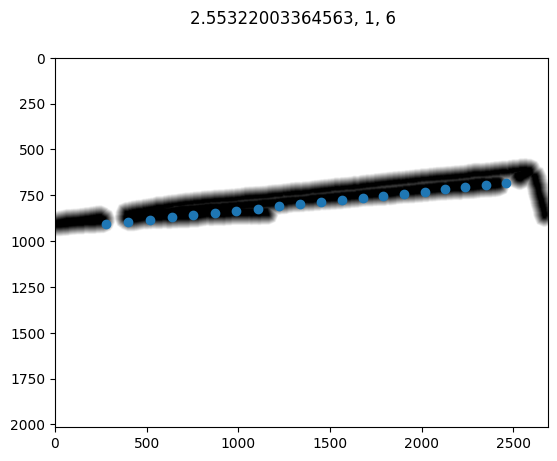

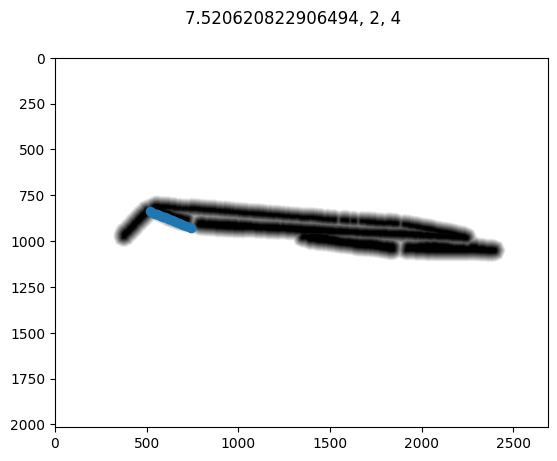

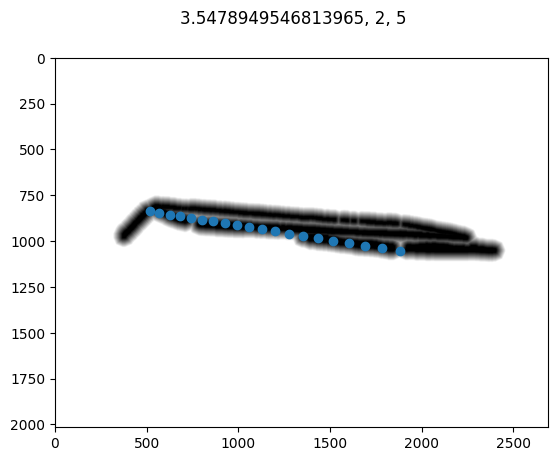

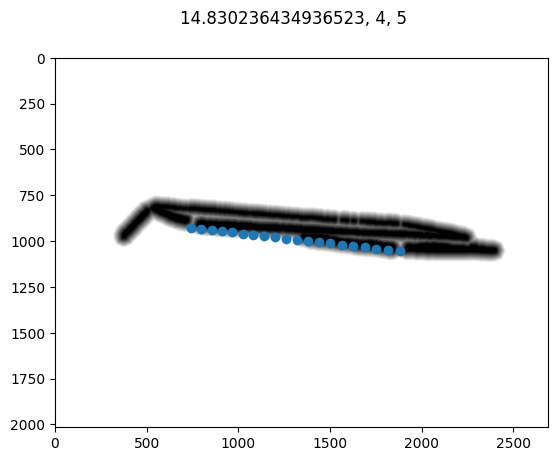

In [764]:
edge_dists = []
uvs = []
for ki in range(N):
    gest = np.array(human_entry['gestalt'][ki])
    edge_mask = 0
    for edge_class in ['eave', 'ridge', 'rake', 'valley']:
        edge_color = np.array(gestalt_color_mapping[edge_class])
        mask = cv2.morphologyEx(cv2.inRange(gest,
                                            edge_color-clr_th,
                                            edge_color+clr_th),
                                cv2.MORPH_DILATE, np.ones((11, 11)))
        edge_mask += mask
    edge_mask = (edge_mask > 0).astype(np.uint8)
    dist = cv2.distanceTransform(1-edge_mask, cv2.DIST_L2, 3)
    # dist[dist > 50] = 50
    edge_dists.append(dist)

    uv = torch.round(pyt_cameras[ki].transform_points(pyt_centers)[:, :2]).cpu().numpy().astype(int)
    uv_inl = (uv[:, 0] >= 0) * (uv[:, 1] >= 0) * (uv[:, 0] < width) * (uv[:, 1] < height)
    uv = uv[uv_inl]
    uvs.append(uv)
# ndist = np.zeros_like(dist)
# ndist = cv2.normalize(dist, ndist, 0, 1.0, cv2.NORM_MINMAX)
# plt.imshow(ndist, cmap='gray')
# plt.imshow(edge_dists[ki], cmap='gray')
# plt.scatter(uv[:, 0], uv[:, 1])

v1 = centers
v2 = centers

for i in range(v1.shape[0]):
    for j in range(i+1, v2.shape[0]):
        points_inter = pyt_centers[i][None] + torch.linspace(0, 1, 20)[:, None].to(device) * (pyt_centers[j][None] - pyt_centers[i][None])
        min_mean_dist = 1000
        best_ki = -1
        best_uvi = -1
        for ki in range(N):
            cki = gestalt_to_colmap_cams[ki]
            in_this_image = np.array([cki in points3D[image_ids[pind]].image_ids for pind in center_inds])
            if not (in_this_image[i] and in_this_image[j]):
                continue
            uvi = torch.round(pyt_cameras[ki].transform_points(points_inter)[:, :2]).cpu().numpy().astype(int)
            mean_dist = edge_dists[ki][uvi[:,1], uvi[:,0]].mean()
            if mean_dist < min_mean_dist:
                min_mean_dist = mean_dist
                best_ki = ki
                best_uvi = uvi
        if best_ki == -1:
            continue
        fig = plt.figure()
        fig.suptitle("{}, {}, {}".format(min_mean_dist, i, j))
        edge_vis = edge_dists[best_ki]
        edge_vis[edge_vis > 50] = 50
        plt.imshow(edge_vis, cmap='gray')
        # plt.scatter(uv[inds, 0], uv[inds, 1])
        plt.scatter(best_uvi[:, 0], best_uvi[:, 1])



In [746]:
# gestalt_to_colmap_cams
points3D[center_inds[6]].image_ids
np.array([points3D[pind].image_ids for pind in center_inds])
center_inds

array([ 2103,   268,  6808,  1441,  5375, 10555,   424])

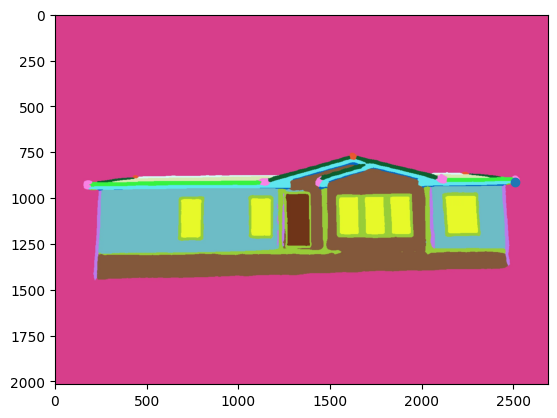

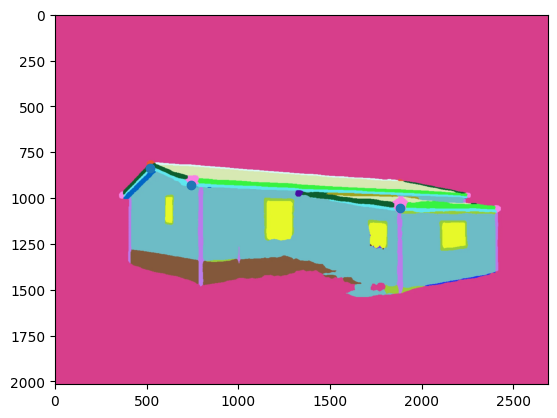

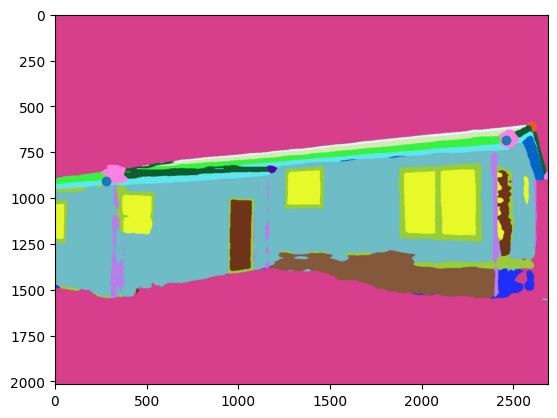

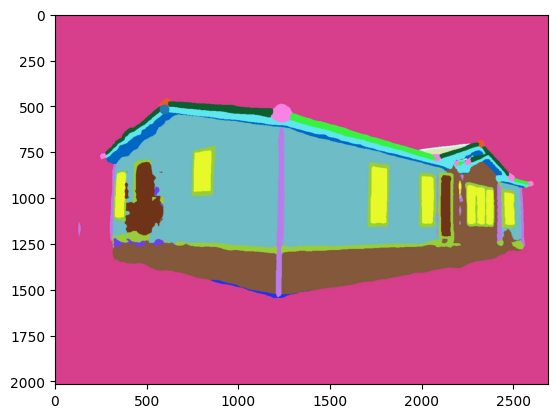

In [763]:
pyt_centers = torch.from_numpy(centers).to(device)
image_ids = np.array([p.id for p in points3D.values()])
for ki in range(N):
    plt.figure()
    gest = np.array(human_entry['gestalt'][ki])
    plt.imshow(gest)

    cki = gestalt_to_colmap_cams[ki]
    in_this_image = np.array([cki in points3D[image_ids[pind]].image_ids for pind in center_inds])

    uv = torch.round(pyt_cameras[ki].transform_points(pyt_centers)[:, :2]).cpu().numpy().astype(int)
    uv = uv[in_this_image]
    uv_inl = (uv[:, 0] >= 0) * (uv[:, 1] >= 0) * (uv[:, 0] < width) * (uv[:, 1] < height)
    uv = uv[uv_inl]
    plt.scatter(uv[:, 0], uv[:, 1])


In [ ]:
# Here is the prediction and visualization of single entry
key, vertices, edges = predict(entry, visualize=True)
# from hoho.viz3d import plot_estimate_and_gt
# plot_estimate_and_gt(   vertices, 
#                         edges,         
#                         np.array(entry['wf_vertices']),
#                         np.array(entry['wf_edges']))

In [589]:
# from hoho import compute_WED

print(compute_WED(vertices,
            edges,
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges']),
            cv=1, ce=1))

compute_WED(vertices,
            edges,
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges']),
            cv=438, ce=1)

9.533268302947222


692.717322328149

In [765]:
vertices0 = np.zeros((2,3))
edges0 = [(0, 1)]

print(compute_WED(vertices0,
            edges0,
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges']),
            cv=1, ce=1))

compute_WED(vertices0,
            edges0,
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges']),
            cv=438, ce=1)

1.08656005603726


38.91330454431985

In [766]:
vertices0 = centers
edges0 = []

print(compute_WED(vertices0,
            edges0,
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges']),
            cv=1, ce=1))

compute_WED(vertices0,
            edges0,
            np.array(entry['wf_vertices']),
            np.array(entry['wf_edges']),
            cv=438, ce=1)

1.0186936779641482


9.187830948296993

In [ ]:
# TODO: separate for eave_end_point and apex

In [ ]:
# world_to_cam = np.eye(4)[None].repeat(3, 0)
# world_to_cam[:, :3, :3] = R
# world_to_cam[:, :3, 3] = T
# cam_to_world =  np.linalg.inv(world_to_cam)